# Geographical analysis for hydrological modelling

This notebook shows how to delineate a catchment and extract properties from a digital elevation model (DEM) and a land-use data set. The processes are hosted on the Raven server, which in the background connects to a GeoServer instance to query watershed contours, DEM and land-use data. 

We connect to Raven's Web Processing Service interface using birdy's `WPSClient`. 

In [1]:
from birdy import WPSClient
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
import os


# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

We first extract the watershed contour for the point of interest. The process looks into the HydroSheds databast to finds the watershed enclosing the given location. The `location` parameter identifies the outlet of the watershed, and `aggregate_upstream` determines whether or not we want the service to return the union of all upstream basins. Here we set it to `False` to reduce the size of the basin and speed-up computations. 

The output of the `hydrosheds-select` process is a GeoJSON geometry. 

In [2]:
r_select = wps.hydrobasins_select(location="-71.291660, 50.492758", aggregate_upstream=False)

In [3]:
# Get GeoJSON polygon of the delineated catchment.
# We can either get links to the files stored on the server, or get the data directly. 
[feature_url, upstream_basins_url] = r_select.get(asobj=False)
[feature, upstream_basins] = r_select.get(asobj=True)
feature

{"geometry": {"coordinates": [[[[-71.3592, 50.4196], [-71.3621, 50.4226], [-71.3625, 50.425], [-71.3629, 50.4358], [-71.3705, 50.4434], [-71.3712, 50.4566], [-71.3746, 50.4601], [-71.3754, 50.4642], [-71.3712, 50.4684], [-71.3705, 50.4733], [-71.367, 50.4767], [-71.3663, 50.4983], [-71.3629, 50.5017], [-71.3621, 50.5108], [-71.3587, 50.5142], [-71.3583, 50.5208], [-71.3561, 50.5203], [-71.348, 50.5131], [-71.3436, 50.5119], [-71.3382, 50.5078], [-71.3353, 50.5089], [-71.3299, 50.5131], [-71.3257, 50.5114], [-71.3243, 50.5009], [-71.3186, 50.4994], [-71.3146, 50.4963], [-71.3105, 50.4994], [-71.3061, 50.5006], [-71.2927, 50.5131], [-71.2883, 50.5115], [-71.2869, 50.5061], [-71.2839, 50.5022], [-71.2833, 50.4958], [-71.2833, 50.4917], [-71.2875, 50.4917], [-71.298, 50.4911], [-71.302, 50.4881], [-71.3105, 50.4869], [-71.3199, 50.4786], [-71.3214, 50.4728], [-71.3306, 50.4632], [-71.3366, 50.4609], [-71.3491, 50.4533], [-71.3488, 50.4529], [-71.3472, 50.4513], [-71.3461, 50.4439], [-71.34

We can now plot the outline of the watershed by loading it into `GeoPandas`. 

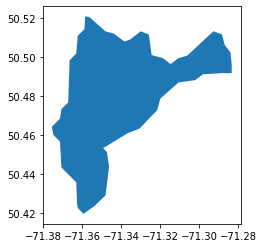

In [4]:
# df = gpd.read_file(feature_url)
df = gpd.GeoDataFrame.from_features([feature])
df.plot()

Now that we have delineated a catchment, lets find the zonal statistics and other properties of the catchment. We can pass the catchment outline either as a link to a file (e.g. `feature_url`), or pass the data directly as a string. 

In [5]:
# Here we are using the geojson file created on the server in the last step as the input value to a process 
# computing watershed properties. 
#crs=4326
#projected_crs=32198
resp = wps.shape_properties(shape=json.dumps(feature))

Now, let's extract the data from the WPS service response:

In [6]:
[properties, ]=resp.get(asobj=True)
prop = properties[0]
print(prop)

area = prop['area']/1000000.0
longitude = prop['centroid'][0]
latitude = prop['centroid'][1]
gravelius = prop['gravelius']
perimeter = prop['perimeter']

shapeProperties = {'area':area, 'longitude':longitude, 'latitude':latitude, 'gravelius':gravelius, 'perimeter':perimeter}
shapeProperties

{'id': '96929', 'gml_id': 'USGS_HydroBASINS_lake_na_lev12.96929', 'HYBAS_ID': 7120270182, 'NEXT_DOWN': 7120270181, 'NEXT_SINK': 7120034330, 'MAIN_BAS': 7120034330, 'DIST_SINK': 490.9, 'DIST_MAIN': 490.9, 'SUB_AREA': 29.0, 'UP_AREA': 9419.6, 'PFAF_ID': 724089370000, 'SIDE': 'R', 'LAKE': 0, 'ENDO': 0, 'COAST': 0, 'ORDER': 1, 'SORT': 96929, 'area': 28764849.46504176, 'centroid': [-71.3409808346398, 50.478880424555875], 'perimeter': 33017.42666655582, 'gravelius': 1.7366297521025682}


{'area': 28.76484946504176,
 'longitude': -71.3409808346398,
 'latitude': 50.478880424555875,
 'gravelius': 1.7366297521025682,
 'perimeter': 33017.42666655582}

Note that these properties are a mix of the properties of the original file where the shape is stored, and properties computed by the process (area, centroid, perimeter and gravelius). Note also that the computed area is in m², while the "SUB_AREA" property is in km², and that there are slight differences between the two values. 

Now we'll extract the land-use properties of the watershed. We pass the link to the watershed outline to a process using in the background the [North American Land Change Monitoring System](http://www.cec.org/tools-and-resources/north-american-environmental-atlas/north-american-land-change-monitoring-system) dataset, and retrieve properties over the region.  

In [7]:
# Use the geoserver to extract the land cover over the appropriate bounding box (automatic)
resp = wps.nalcms_zonal_stats(shape=feature_url, select_all_touching=True, band=1, simple_categories=True)

In [8]:
# Note that geojson needs to be installed for this to work. 
# $ pip install -r requirements_extra.txt
features, statistics  = resp.get(asobj=True)
print(features[0]['properties'], '\n\n')
print(statistics)

{'id': '96929', 'gml_id': 'USGS_HydroBASINS_lake_na_lev12.96929', 'HYBAS_ID': 7120270182, 'NEXT_DOWN': 7120270181, 'NEXT_SINK': 7120034330, 'MAIN_BAS': 7120034330, 'DIST_SINK': 490.9, 'DIST_MAIN': 490.9, 'SUB_AREA': 29.0, 'UP_AREA': 9419.6, 'PFAF_ID': 724089370000, 'SIDE': 'R', 'LAKE': 0, 'ENDO': 0, 'COAST': 0, 'ORDER': 1, 'SORT': 96929, '1': 13532, '2': 335, '5': 4367, '6': 847, '8': 10239, '10': 60, '12': 380, '14': 21, '16': 39, '18': 3248, 'count': 33068, 'nodata': 8.0, 'nan': 0, 'Ocean': 0, 'Forest': 19081, 'Shrubs': 10239, 'Grass': 479, 'Wetland': 21, 'Crops': 0, 'Urban': 0, 'Water': 3248, 'SnowIce': 0} 


[{'Ocean': 0, 'Forest': 19081, 'Shrubs': 10239, 'Grass': 479, 'Wetland': 21, 'Crops': 0, 'Urban': 0, 'Water': 3248, 'SnowIce': 0}]


In [9]:
features

{"features": [{"geometry": {"coordinates": [[[[1981874.096748, 967399.091191], [1981560.497165, 967640.799616], [1981434.936988, 967882.780767], [1980961.263774, 969007.129417], [1980150.453239, 969613.136897], [1979557.788254, 970982.006618], [1979190.993435, 971263.662311], [1978968.917959, 971674.108713], [1979068.737029, 972221.498664], [1978911.276644, 972753.897266], [1978998.518432, 973199.540058], [1978148.536013, 975486.000658], [1978229.072674, 975929.06883], [1977903.742496, 976905.067086], [1977984.173254, 977348.115496], [1977736.398881, 978051.400822], [1977900.425286, 978054.503503], [1978726.767107, 977503.147592], [1979063.162155, 977488.410214], [1979585.086481, 977194.438111], [1979728.314495, 977383.335657], [1979905.626466, 977961.050647], [1980249.760066, 977888.82216], [1980777.020525, 976821.614008], [1981210.625424, 976808.412368], [1981599.965266, 976584.172313], [1981738.25575, 977013.547429], [1981974.993178, 977251.010851], [1982328.051065, 978903.0378], [1

We now have the statistics from the NALCMS zonal_stats toolbox regarding the land use, from which we calculate the ratio of each land-use component.

In [10]:
# total = sum(lu.values())
lu = statistics[0]
total = sum(lu.values())

landUse = {k: (v / total) for (k,v) in lu.items()}
landUse

{'Ocean': 0.0,
 'Forest': 0.5770231039071005,
 'Shrubs': 0.3096346921495101,
 'Grass': 0.014485303011975323,
 'Wetland': 0.0006350550381033022,
 'Crops': 0.0,
 'Urban': 0.0,
 'Water': 0.09822184589331075,
 'SnowIce': 0.0}

The next step will be to collect terrain data, such as elevation, slope and aspect. We will do this using the `terrain_analysis` WPS service:

In [11]:
resp = wps.terrain_analysis(shape=feature_url, select_all_touching=True, projected_crs=3978)

Now let's extract the properties from the WPS response. Use `asobj=True` to have Birdy preprocess the data and return the data directly.

In [12]:
properties, dem = resp.get(asobj=True)

elevation=properties[0]['elevation']
slope=properties[0]['slope']
aspect=properties[0]['aspect']

terrain_data={'elevation':elevation, 'slope':slope,'aspect':aspect}

Finally, display all the extracted parameters for the user:

In [13]:
all_properties={**shapeProperties, **landUse, **terrain_data}
print(all_properties)

{'area': 28.76484946504176, 'longitude': -71.3409808346398, 'latitude': 50.478880424555875, 'gravelius': 1.7366297521025682, 'perimeter': 33017.42666655582, 'Ocean': 0.0, 'Forest': 0.5770231039071005, 'Shrubs': 0.3096346921495101, 'Grass': 0.014485303011975323, 'Wetland': 0.0006350550381033022, 'Crops': 0.0, 'Urban': 0.0, 'Water': 0.09822184589331075, 'SnowIce': 0.0, 'elevation': 490.04395604395603, 'slope': 3.9660612485567572, 'aspect': 116.79663053081183}


Note here that while the feature outline is defined above in terms of geographic coordinates (latitude, longitude), the DEM is projected onto a 2D cartesion coordinate system (here NAD83, the Canada Atlas Lambert projection). This is necessary to perform slope calculations. 

For more information on this, see: https://en.wikipedia.org/wiki/Map_projection

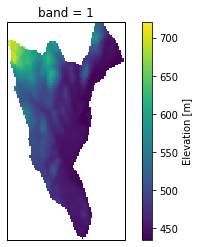

In [14]:
# NBVAL_SKIP
import cartopy.crs as ccrs
import rasterio
from rasterio.plot import show
import xarray as xr
import rasterio
from rasterio.io import MemoryFile

with MemoryFile(dem) as mem:
    with mem.open(driver='gtiff') as src:
        crs = ccrs.LambertConformal(central_latitude=49, central_longitude=-95, standard_parallels=(49, 77))
        da = xr.open_rasterio(src)
        da.name = 'Elevation'
        da.attrs['units'] = 'm'
        ax = plt.subplot(projection=crs)
        da.where(da!=-32768).sel(band=1).plot.imshow(ax=ax, transform=crs)
        plt.show()